In [ ]:
%matplotlib notebook
import cmocean
import cartopy
import cartopy.crs as ccrs
import matplotlib as plt
import os
import numpy as np
from pynextsim.gmshlib import GmshMesh

import mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import matplotlib.pyplot as plt
from pynextsim.nextsim_bin import NextsimBin
from pynextsim.openers import OpenerVariable, Opener, ProjectionInfo
import datetime as dt
import pynextsim.lib as nsl

from string import Template


In [2]:
class GmshMeshX(GmshMesh):
    def get_grid(self, resolution=10000):
        """
        Parameters:
        -----------
        resolution : float
            resolution in metres

        Returns:
        --------
        grid : pynextsim.gridding.Grid
        """
        return png.Grid.init_from_grid_params(
                dict(
                    xmin = self.boundary.xmin-100000,
                    xmax = self.boundary.xmax,
                    ymin = self.boundary.ymin,
                    ymax = self.boundary.ymax+100000,
                    nx = int(np.ceil((self.boundary.xmax - self.boundary.xmin)/resolution)),
                    ny = int(np.ceil((self.boundary.ymax - self.boundary.ymin)/resolution)),
                    ))

# create TOPAZ opener
class OpenerTopaz4(Opener):
    name = 'TOPAZ4'
    name_mask = 'TOPAZ4/198910_201512/TP4DAILY_%Y%m_30m.nc'
    
    # variables
    variables = dict(
            uvel = OpenerVariable('u'), 
            vvel = OpenerVariable('v'),
            ssh = OpenerVariable('ssh'),
            )
    averaging_period = 1 # daily average

    #def __init__(self, forecast_start_date):
    #    self.name_mask = 'TOPAZ4/198910_201512/TP4DAILY_' + forecast_start_date.strftime('TOPAZ4/198910_201512/TP4DAILY_%Y%m%d_30m.nc')
     #   self.forecast_start_date = forecast_start_date

    @property
    def projection(self):
        '''
        TOPAZ/hyc2proj projection
        '''
        return ProjectionInfo.topaz_np_stere()
    

In [3]:
# get TOPAZ data

# calculate current speed from TOPAZ for 15-feb-2013

# input
dto = dt.datetime(2013,2,15)

meshfile = os.path.join(os.getenv('NEXTSIM_MESH_DIR'), 'medium_arctic_10km.msh')
plot_res = 10 #km

# get target grid
gmsh = GmshMeshX(meshfile)
grid = gmsh.get_grid(resolution=plot_res*1000)

bbox=[-3499800.489225414, 3691904.3194155763, -4178720.947330964, 2721150.5288251294]

data=[]
for varname in ['u', 'v']:
    op = OpenerTopaz4()
    f=op.find(dto)
    nci = mnu.nc_getinfo(f)
    tind = nci.datetimes.index(dto)
    data += [grid.get_netcdf_data(nci, vlist=[varname], time_index=tind)[varname]]

    
spd = np.hypot(*data) 
    
# spd_ave.mean()


Reading /cluster/projects/nn2993k/sim/mesh/medium_arctic_10km.msh...

Finished reading /cluster/projects/nn2993k/sim/mesh/medium_arctic_10km.msh.

reduce grid bbox:  (-2351251.6518098847, 2747295.8559726127, -1877161.4941990748, 2118359.1614414966)
reduce grid bbox:  (-2351251.6518098847, 2747295.8559726127, -1877161.4941990748, 2118359.1614414966)


<IPython.core.display.Javascript object>


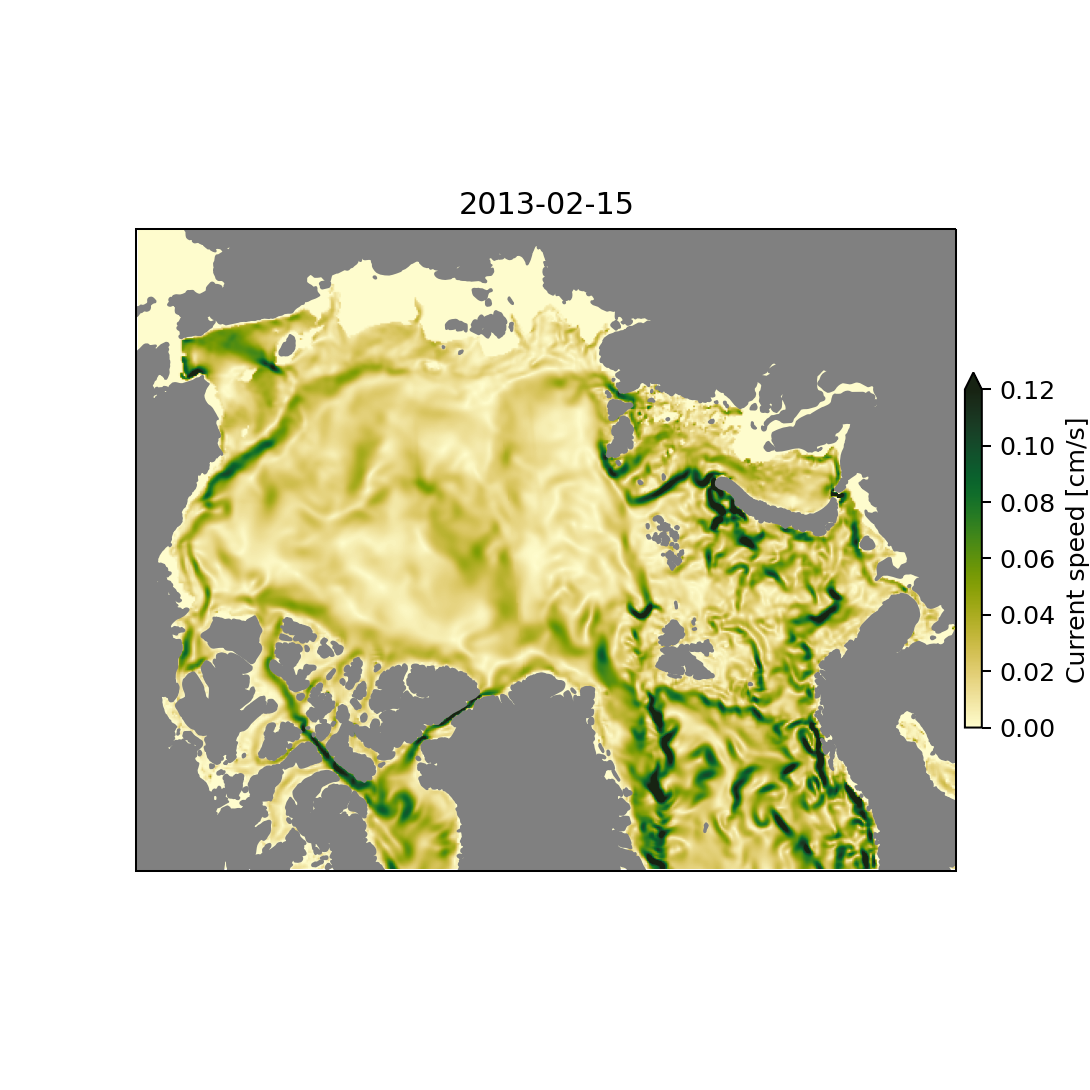

Text(0.5, 1.0, '2013-02-15')

In [20]:
# Plot current speed 
cmap = cmocean.cm.speed
x_extent = [grid.xy[0][0][0], grid.xy[0][0][-1]]
y_extent = [grid.xy[1][0][0], grid.xy[1][-1][0]]
extent=[*x_extent, *y_extent]

# prepare figure with projection
crs = grid.projection.crs
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=crs)

#ax.coastlines(resolution='10m', linewidth=0.5)
kw = dict(zorder=1, alpha=1, facecolor='grey')
ax.add_feature(cartopy.feature.LAND, **kw)


im = ax.imshow(spd, cmap=cmap, origin='lower',
                    extent=extent, vmin=0, vmax=0.12)
ax.set_extent(extent, crs=crs)
ax.set_aspect(1)

cbar=fig.colorbar(im, ax=ax, extend='max', pad=0.01,  fraction=0.02, label='Current speed [cm/s]')

ax.set_title(dto.strftime('%Y-%m-%d'))


Compare to barotropic velocity maps from Armitage et al. (2017), the TOPAZ reanalysis overestimate the strength of the coastal current in the Beaufort Sea. In particular off the Alaskan coast and Point Barrow. This may contribute to high stress exerted on the ice pack.    



In [29]:
m=np.arange(1, 13,730)
print(m)


[1]
